# Stochastic Weight Averaging Gaussian Mixtures (SWAGM)

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import operator

import os
import sys
import shutil
sys.path.append("../src") if "../src" not in sys.path else None 

# custom imports
from methods import *
from nnmodules import GenericDNN
from swag import *
from swagm import *
from evaluation import * 

### Initialize Data and Model

In [3]:
# choose dataset to use
dataset_name = 'yacht.txt'#'energy_heating_load.txt'#
datasets_path = '../datasets/'
dataset_path = datasets_path + dataset_name

# load data and create torch training data loader
(X_train, y_train), (X_test, y_test) = load_data(dataset_path)
trainloader = torch.utils.data.DataLoader(Dataset(X_train, y_train, dataset_name.split('.')[0]), 
                                         batch_size:=32, shuffle:=True)

testloader = torch.utils.data.DataLoader(Dataset(X_test, y_test, dataset_name.split('.')[0], normalize=False), 
                                         shuffle=False)

# init model, criterion and optimizer
def init_net():
    """
    Easily reinstantiate net (reinitialise weights), criterion and 
    optimizer with same hyper-params
    """
    net = GenericDNN(input_size:=X_train.shape[-1], hidden_size:=input_size, output_size:=1)
    criterion = torch.nn.MSELoss()#L1Loss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    return net, criterion, optimizer

In [19]:
len(trainloader.dataset[0][0])

6

### Choose whether to train weights (SWAG), and do inference

In [4]:
# Set 'train:=True' if model not previously trained, or want to train a new model
checkpoint_path = '../checkpoints/'
if train:=True:
        
    # delete previous checkpoints for model with current dataset
    if delete_previous_checkoints:=True:
        try:
            shutil.rmtree(checkpoint_path + trainloader.dataset.name + '-swagm')
        except FileNotFoundError:
            # can't delete non-existing file... just carry on
            pass
    
    # train and save weights
    train_swagm(
        init_net=init_net,
        nmixtures=5,
        trainloader=trainloader,
        init_epochs=1000,
        sampling_epochs=5,
        nsamples=200,
        path_to_checkpoints="../checkpoints/",
    )

TRAINING SWAGM using SWAG nmixtures=5 times
Training to initial weight-solution (MLE)


100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 151.15it/s]


Iterate/train further from initial weight-solution ('Sample' around posterior mode)


100%|█████████████████████████████████████████| 200/200 [00:06<00:00, 31.33it/s]


Training to initial weight-solution (MLE)


100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 157.11it/s]


Iterate/train further from initial weight-solution ('Sample' around posterior mode)


100%|█████████████████████████████████████████| 200/200 [00:06<00:00, 32.26it/s]


Training to initial weight-solution (MLE)


100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 153.78it/s]


Iterate/train further from initial weight-solution ('Sample' around posterior mode)


100%|█████████████████████████████████████████| 200/200 [00:06<00:00, 30.39it/s]


Training to initial weight-solution (MLE)


100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 164.63it/s]


Iterate/train further from initial weight-solution ('Sample' around posterior mode)


100%|█████████████████████████████████████████| 200/200 [00:06<00:00, 29.26it/s]


Training to initial weight-solution (MLE)


100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 165.54it/s]


Iterate/train further from initial weight-solution ('Sample' around posterior mode)


100%|█████████████████████████████████████████| 200/200 [00:06<00:00, 29.27it/s]


In [5]:
collect_similar_modes(name=trainloader.dataset.name, nsamples=1000, alpha=0.05, checkpoint_path='../checkpoints/')

ALPHA_corrected is alpha/(n**2 - n) = 0.0025
The null-hypothesis H_0 is: Samples come from the same distribution
p_value=tensor(0.) for samples: swagm001 and swagm000. Thus, <<<H0 is FALSE>>>. Continuing.
p_value=tensor(0.) for samples: swagm001 and swagm002. Thus, <<<H0 is FALSE>>>. Continuing.
p_value=tensor(0.) for samples: swagm001 and swagm004. Thus, <<<H0 is FALSE>>>. Continuing.
p_value=tensor(0.) for samples: swagm001 and swagm003. Thus, <<<H0 is FALSE>>>. Continuing.
p_value=tensor(0.) for samples: swagm000 and swagm001. Thus, <<<H0 is FALSE>>>. Continuing.
p_value=tensor(0.) for samples: swagm000 and swagm002. Thus, <<<H0 is FALSE>>>. Continuing.
p_value=tensor(0.) for samples: swagm000 and swagm004. Thus, <<<H0 is FALSE>>>. Continuing.
p_value=tensor(0.) for samples: swagm000 and swagm003. Thus, <<<H0 is FALSE>>>. Continuing.
p_value=tensor(0.) for samples: swagm002 and swagm001. Thus, <<<H0 is FALSE>>>. Continuing.
p_value=tensor(0.) for samples: swagm002 and swagm000. Thus

### Do predictions

In [13]:
net, criterion, optimizer = init_net()
theta_SWAs, cov_diags, Ds, catdist = inference_swagm(trainloader.dataset.name, checkpoint_path)

# Do predictions
Lpi, Upi, mu_pred = monte_carlo_PI_swagm(trainloader.dataset[:][0], net, theta_SWAs, cov_diags, 
                                        Ds, catdist, nsamples=50, percentile=0.9)

# invert prediction normalization
invert_normalization = lambda y: y * trainloader.dataset.stdy + trainloader.dataset.muy
Lpi, Upi, mu_pred, y_true = map(invert_normalization, (Lpi, Upi, mu_pred, trainloader.dataset[:][1]))

probs=tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])


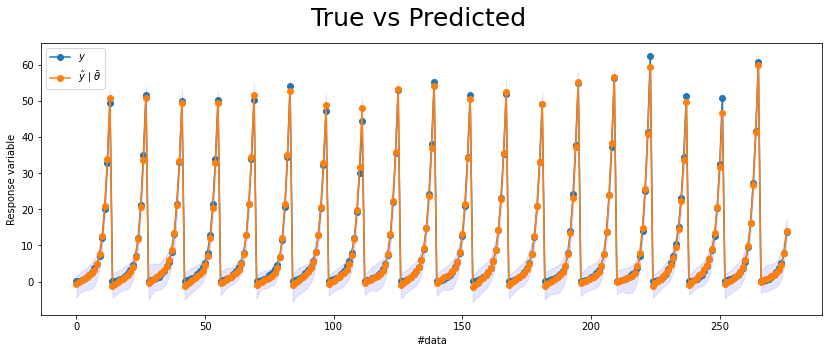

In [14]:
# plotting
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(y_true, "-o", label="$y$")
#ax.plot(mu_swa[:,0], "-o", label="$\\hat{y} \\mid \\theta_{SWA}$")
ax.plot(mu_pred[:,0], "-o", label="$\\hat{y} \\mid \\bar{\\theta}$")
ax.set_xlabel("#data")
ax.set_ylabel("Response variable")
ax.legend()
fig.suptitle("True vs Predicted", size=25)
ax.fill_between(np.arange(len(y_train)), Lpi[:,0], Upi[:,0], color='b', alpha=.1)

In [16]:
# evaluate model
print(f"{rmse(y_true, mu_pred)=}, {picp(Lpi, Upi, y_true)=}, {mpiw(Lpi, Upi)=}")

rmse(y_true, mu_pred)=0.6942464, picp(Lpi, Upi, y_true)=0.9927797833935018, mpiw(Lpi, Upi)=6.3331084


In [ ]:
# Plot uncertainty curve and PI difference
# - We expect the PI to be wider where there is few data points, i.e. at the peaks of the "yatch.txt" 
# dataset, but the plot above does not seem to support this fact. However, when the graph "grows"
# quickly, the PI width appears thin, while it in reality is actually wider. 
# This can be seen from the follow plot: I.e. that the PI difference grows near the peaks, and
# becomes smaller near the troughs.
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(Upi[:,0] - Lpi[:,0], label='PI-difference')
ax.fill_between(np.arange(len(y_train)), Lpi[:,0], Upi[:,0], color='b', alpha=.1)
ax.legend()
plt.xlabel('#data')
plt.ylabel('PI for $\hat{y}$')
plt.title('PI and PI upper and lower bound difference', size=25)

Text(0.5, 1.0, 'True vs Predicted')

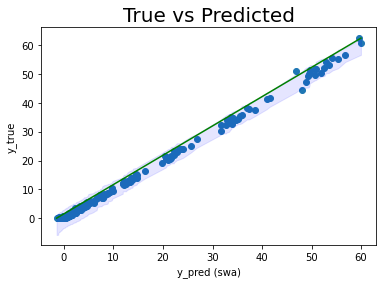

In [20]:
# plot pred and true against each other
plt.plot([np.min(mu_pred),np.max(mu_pred)], \
         [np.min(y_true.detach().numpy()),np.max(y_true.detach().numpy())], color="green")
plt.scatter(mu_pred[:,0], y_true[:,0])
plt.fill_between(np.sort(mu_pred[:,0]), np.sort(Lpi[:,0]), np.sort(Upi[:,0]), color='b', alpha=.1)
plt.xlabel('y_pred (swa)')
plt.ylabel('y_true')
plt.title('True vs Predicted',size=20)